In [1]:
import pandas as pd
import joblib
from datetime import datetime, timedelta

def predict_water_days(start_date=None, days=30):
    """
    Load the saved Prophet model and make predictions for water usage.

    Parameters:
    -----------
    start_date : str or datetime, optional
        The start date for predictions in 'YYYY-MM-DD' format.
        If None, defaults to current date.
    days : int, optional
        Number of days to forecast, default is 30.

    Returns:
    --------
    pandas.DataFrame
        Forecast dataframe with columns:
        - ds: prediction date
        - yhat: predicted value (days water lasted)
        - yhat_lower: lower bound of prediction interval
        - yhat_upper: upper bound of prediction interval
    """
    # Load the saved model
    try:
        model = joblib.load("/content/water_days_prophet_model.pkl")
    except FileNotFoundError:
        raise FileNotFoundError("Model file 'water_days_prophet_model.pkl' not found. Please ensure the model file exists in the current directory.")

    # Set start date to today if not provided
    if start_date is None:
        start_date = datetime.now()
    elif isinstance(start_date, str):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')

    # Create future dataframe for the specified period
    future = pd.DataFrame({
        'ds': [start_date + timedelta(days=i) for i in range(days)]
    })

    # Make predictions
    forecast = model.predict(future)

    # Select relevant columns
    result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    return result

def get_water_days_summary(forecast):
    """
    Generate a summary of water days forecast.

    Parameters:
    -----------
    forecast : pandas.DataFrame
        Forecast dataframe from predict_water_days function

    Returns:
    --------
    dict
        Dictionary containing summary statistics
    """
    summary = {
        'average_days': forecast['yhat'].mean(),
        'min_days': forecast['yhat'].min(),
        'min_date': forecast.loc[forecast['yhat'].idxmin(), 'ds'].date(),
        'max_days': forecast['yhat'].max(),
        'max_date': forecast.loc[forecast['yhat'].idxmax(), 'ds'].date()
    }

    return summary

# Example usage
if __name__ == "__main__":
    # Example: Predict for the next 30 days starting from today
    forecast = predict_water_days()

    # Print forecast summary
    summary = get_water_days_summary(forecast)
    print("\nWater Days Forecast Summary:")
    print(f"Average predicted days water lasted: {summary['average_days']:.2f}")
    print(f"Minimum predicted days: {summary['min_days']:.2f} on {summary['min_date']}")
    print(f"Maximum predicted days: {summary['max_days']:.2f} on {summary['max_date']}")

    # Save predictions to CSV
    forecast.to_csv(f"water_forecast_{datetime.now().strftime('%Y%m%d')}.csv", index=False)
    print(f"Forecast saved to water_forecast_{datetime.now().strftime('%Y%m%d')}.csv")


Water Days Forecast Summary:
Average predicted days water lasted: 24.19
Minimum predicted days: 23.54 on 2025-03-21
Maximum predicted days: 27.42 on 2025-03-31
Forecast saved to water_forecast_20250316.csv


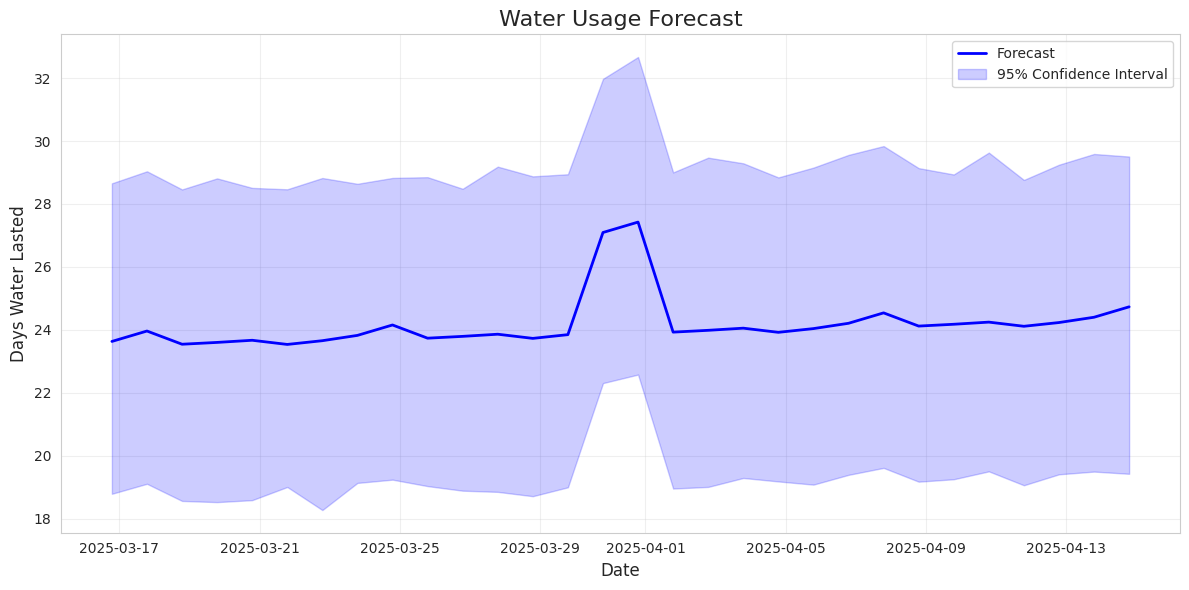

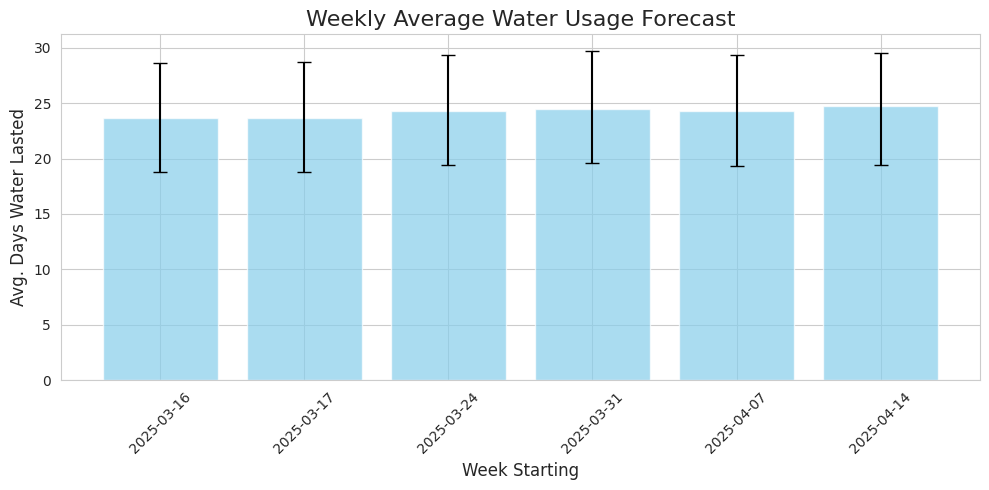

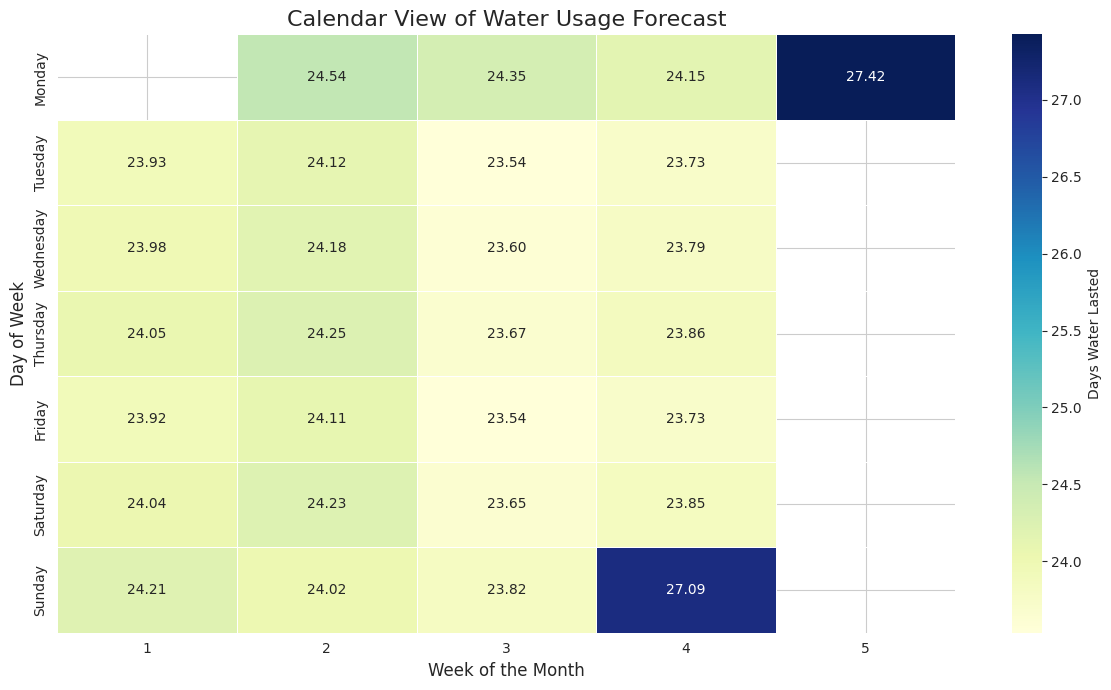

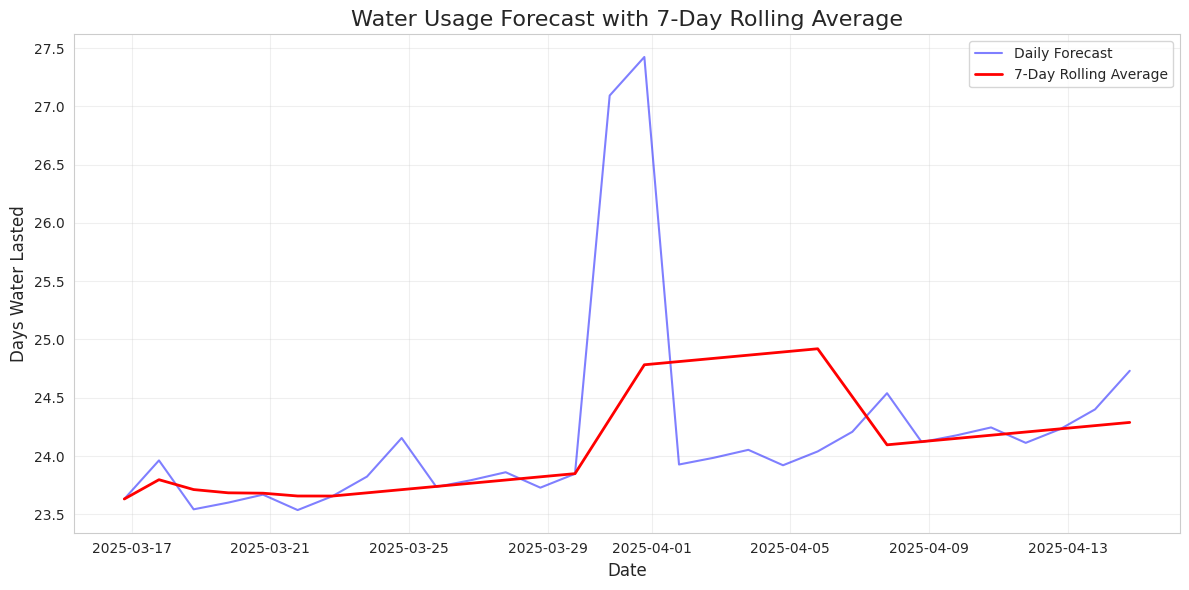

Visualizations and summary created successfully. Files saved to current directory
Summary file: water_forecast_summary_20250316.txt
Created 5 visualization files.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

def visualize_water_forecast(csv_file=None, save_path=None, show_plots=True):
    """
    Create visualizations from water forecast CSV results.

    Parameters:
    -----------
    csv_file : str, optional
        Path to the forecast CSV file. If None, will try to find the most recent
        water_forecast_*.csv file in the current directory.
    save_path : str, optional
        Directory to save visualizations. If None, saves to current directory.
    show_plots : bool, optional
        Whether to display the plots (default True).

    Returns:
    --------
    dict
        Dictionary containing file paths of saved visualizations
    """
    # Find the most recent forecast CSV if not specified
    if csv_file is None:
        csv_files = [f for f in os.listdir() if f.startswith('water_forecast_') and f.endswith('.csv')]
        if not csv_files:
            # Try April forecast from original script
            if os.path.exists('/content/water_forecast_20250316.csv'):
                csv_file = '/content/water_forecast_20250316.csv'
            else:
                raise FileNotFoundError("No water forecast CSV files found in the current directory.")
        else:
            csv_file = sorted(csv_files)[-1]  # Get the most recent one

    # Set save path
    if save_path is None:
        save_path = ''
    else:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

    # Load the forecast data
    df = pd.read_csv(csv_file)

    # Ensure datetime format
    df['ds'] = pd.to_datetime(df['ds'])

    # Set plotting style
    sns.set_style('whitegrid')
    plt.rcParams['figure.figsize'] = (12, 6)

    # Dictionary to store paths of saved visualizations
    visualization_files = {}

    # 1. Main forecast plot with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['yhat'], label='Forecast', color='blue', linewidth=2)
    plt.fill_between(df['ds'], df['yhat_lower'], df['yhat_upper'],
                     alpha=0.2, color='blue', label='95% Confidence Interval')

    plt.title('Water Usage Forecast', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Days Water Lasted', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    main_plot_file = os.path.join(save_path, f'water_forecast_plot_{datetime.now().strftime("%Y%m%d")}.png')
    plt.savefig(main_plot_file, dpi=300, bbox_inches='tight')
    visualization_files['main_plot'] = main_plot_file

    if show_plots:
        plt.show()
    else:
        plt.close()

    # 2. Weekly average plot
    df['week'] = df['ds'].dt.isocalendar().week
    weekly_avg = df.groupby('week').agg({
        'yhat': 'mean',
        'yhat_lower': 'mean',
        'yhat_upper': 'mean',
        'ds': lambda x: min(x).strftime('%Y-%m-%d')  # Get first day of week
    }).reset_index()

    plt.figure(figsize=(10, 5))
    plt.bar(weekly_avg['ds'], weekly_avg['yhat'],
            yerr=[weekly_avg['yhat']-weekly_avg['yhat_lower'], weekly_avg['yhat_upper']-weekly_avg['yhat']],
            capsize=5, color='skyblue', alpha=0.7)

    plt.title('Weekly Average Water Usage Forecast', fontsize=16)
    plt.xlabel('Week Starting', fontsize=12)
    plt.ylabel('Avg. Days Water Lasted', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot
    weekly_plot_file = os.path.join(save_path, f'weekly_water_forecast_{datetime.now().strftime("%Y%m%d")}.png')
    plt.savefig(weekly_plot_file, dpi=300, bbox_inches='tight')
    visualization_files['weekly_plot'] = weekly_plot_file

    if show_plots:
        plt.show()
    else:
        plt.close()

    # 3. Heatmap calendar view
    if len(df) >= 28:  # Only create if we have enough data
        df['dow'] = df['ds'].dt.day_name()
        df['week_num'] = (df['ds'].dt.day - df['ds'].dt.dayofweek) // 7 + 1

        # Create a pivot table for the heatmap
        pivot_df = df.pivot_table(index='dow',
                                  columns='week_num',
                                  values='yhat',
                                  aggfunc='mean')

        # Reorder days of week
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot_df = pivot_df.reindex(days_order)

        plt.figure(figsize=(12, 7))
        ax = sns.heatmap(pivot_df, annot=True, fmt='.2f', cmap='YlGnBu',
                         linewidths=.5, cbar_kws={'label': 'Days Water Lasted'})

        plt.title('Calendar View of Water Usage Forecast', fontsize=16)
        plt.xlabel('Week of the Month', fontsize=12)
        plt.ylabel('Day of Week', fontsize=12)
        plt.tight_layout()

        # Save the plot
        calendar_plot_file = os.path.join(save_path, f'calendar_water_forecast_{datetime.now().strftime("%Y%m%d")}.png')
        plt.savefig(calendar_plot_file, dpi=300, bbox_inches='tight')
        visualization_files['calendar_plot'] = calendar_plot_file

        if show_plots:
            plt.show()
        else:
            plt.close()

    # 4. Plot with 7-day rolling average trend
    df['rolling_avg'] = df['yhat'].rolling(window=7, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(df['ds'], df['yhat'], label='Daily Forecast', color='blue', alpha=0.5)
    plt.plot(df['ds'], df['rolling_avg'], label='7-Day Rolling Average',
             color='red', linewidth=2)

    plt.title('Water Usage Forecast with 7-Day Rolling Average', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Days Water Lasted', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    # Save the plot
    trend_plot_file = os.path.join(save_path, f'trend_water_forecast_{datetime.now().strftime("%Y%m%d")}.png')
    plt.savefig(trend_plot_file, dpi=300, bbox_inches='tight')
    visualization_files['trend_plot'] = trend_plot_file

    if show_plots:
        plt.show()
    else:
        plt.close()

    # Generate summary statistics
    summary = {
        'avg_days': df['yhat'].mean(),
        'min_days': df['yhat'].min(),
        'min_date': df.loc[df['yhat'].idxmin(), 'ds'].strftime('%Y-%m-%d'),
        'max_days': df['yhat'].max(),
        'max_date': df.loc[df['yhat'].idxmax(), 'ds'].strftime('%Y-%m-%d'),
        'std_dev': df['yhat'].std(),
        'below_avg_days': (df['yhat'] < df['yhat'].mean()).sum()
    }

    # Create a summary text file
    summary_file = os.path.join(save_path, f'water_forecast_summary_{datetime.now().strftime("%Y%m%d")}.txt')
    with open(summary_file, 'w') as f:
        f.write(f"Water Forecast Summary (Generated on {datetime.now().strftime('%Y-%m-%d')})\n")
        f.write(f"=================================================================\n\n")
        f.write(f"Source file: {csv_file}\n")
        f.write(f"Time period: {df['ds'].min().strftime('%Y-%m-%d')} to {df['ds'].max().strftime('%Y-%m-%d')}\n\n")
        f.write(f"Key Statistics:\n")
        f.write(f"  - Average days water lasted: {summary['avg_days']:.2f}\n")
        f.write(f"  - Minimum days: {summary['min_days']:.2f} on {summary['min_date']}\n")
        f.write(f"  - Maximum days: {summary['max_days']:.2f} on {summary['max_date']}\n")
        f.write(f"  - Standard deviation: {summary['std_dev']:.2f}\n")
        f.write(f"  - Days below average: {summary['below_avg_days']} out of {len(df)}\n\n")
        f.write(f"Visualization files created:\n")
        for key, path in visualization_files.items():
            f.write(f"  - {key}: {path}\n")

    visualization_files['summary'] = summary_file

    print(f"Visualizations and summary created successfully. Files saved to {save_path or 'current directory'}")
    print(f"Summary file: {summary_file}")

    return visualization_files

# Example usage
if __name__ == "__main__":
    # Try to find and visualize the most recent forecast
    try:
        visualization_files = visualize_water_forecast()
        print(f"Created {len(visualization_files)} visualization files.")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please run this script after generating a forecast CSV file.")